# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [1]:
# This part probably will be enough for utilizing Drive in Colab
# but examine links above if you encounter with problems.
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

## I RAN IT ON LOCAL


# Now, you will work on the problem of Insect Pest Recognition using IP102 data, where you have 8 classes

After having mounted the Jupyter Notebook to Google Drive, navigate the following address:

https://drive.google.com/open?id=1qrl7JtGtOEtcYAbD5wX2D538VQNmeC8C

Add this folder entirely to your Google Drive. If you have done it correctly, then you should be able to see IP102 in your drive.

You can examine info about the dataset in this github repo: 
https://github.com/xpwu95/IP102



### Don't forget to choose the right runtime from the menu above. (GPU should be selected)

In [2]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Tue Nov 19 17:12:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P0    66W / 275W |    264MiB / 11175MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

You are free to utilize Pytorch methods in this part of the Homework. 
You will be using pretained models ResNet50, DenseNet-121 and your own model.

Below, you will find required modules loaded. 

In [3]:
# All libraries are already presented in Colab Servers, we don't need to install anything with pip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import normalize, resize, to_tensor
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

torch.backends.cudnn.benchmark=True

%matplotlib inline

## DataLoader and Dataset
Here, we provide you an fully functional Dataset but to ensure that you understood how it works. You can change some parts if you want to train with subset of dataset at first.

In [4]:
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

### The code below is to make you be able to load by using Pillow.
class IPLoader(Dataset):
    def __init__(self, path, mode='train'):
        self.class_num = 8
        self.images_splitted = '{}/Images_Splitted/'.format(path)
        self.file_path = '{}/{}.txt'.format(path,mode)
        self.mode = mode
        self.images = []
        with open(self.file_path, 'r') as f:
             self.images = f.readlines()
        print(len(self.images))
        
    # There are 102 classes in original dataset but we will use 8 super classes in order to classify easily.
    def get_super_label(self,num):
        if num <= 14:
          return 0
        elif num <= 27:
          return 1
        elif num <= 36:
          return 2
        elif num <= 44:
          return 3
        elif num <= 57:
          return 4
        elif num <= 73:
          return 5
        elif num <= 92:
          return 6
        else:
          return 7 
            
    # This method normalizes each image individually. You may want to normalize it by using ImageNet statistics
    # If you would like to fine tune so feel free to do changes
    def preprocess(self, x):
        x = resize(x, (224, 224)) # Resnet, Densenet
        #x = resize(x, (256, 256)) # You can use different input size for your model such as 256x256
        x = np.asarray(x)
        x = x.transpose((2,0,1))
        x = torch.from_numpy(x).type(torch.float)
        #normalize(x,  mean=[el.mean() for el in x] ,std=[el.std() for el in x]) # Channel Standard Normalization
        x = normalize(x,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Imagenet Normalization
        return x
    
    # This method basically loads image from the file system
    def load(self, path):
        img = Image.open(path)
        img.load()
        return img

    # This method gets one item in order to construct batches
    def __getitem__(self, ix):
        image = self.images[ix]
        line = image.split()
        path = '{}{}_{}/'.format(self.images_splitted,self.mode,ix // 1000)
        
        #Get its relative path and label
        data_path = '{}{}'.format(path,line[0])
        label = self.get_super_label(int(line[1]))
        
        # Load image
        data = self.load(data_path)

        #There are some files with 4 channels we take only RGB channels of them
        if not np.array(data).shape[2] == 3:
            data = np.array(data)
            data = data[:,:,:3]
            data = Image.fromarray(data)
        
        # Do Prepocessing on data
        data_normalized = self.preprocess(data)
        
        # Then return the data and its label.
        return data_normalized, label
        
        
    # This method gives number of samples in dataset
    def __len__(self):
        return len(self.images)

# Load separately ResNet and DenseNet models

You can find tutorials on how to load those models at pytorch.org . Don't forget to use pretrained=True if you wish to do finetuning.

In [5]:
# Load models here

resnet_model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet50', pretrained=True)
densenet_model = torch.hub.load('pytorch/vision:v0.4.2', 'densenet121', pretrained=True)

Using cache found in /home/nlztrk/.cache/torch/hub/pytorch_vision_v0.4.2
Using cache found in /home/nlztrk/.cache/torch/hub/pytorch_vision_v0.4.2


# Additionally, build your own model which is different from the other models, train on the IP dataset
**Report your loss curves at the end of the notebook**

In [6]:
###  Here are some training parameters
batch_size = 64
use_gpu = True
###

# You may want to tweak them too.

criteria = nn.CrossEntropyLoss()

In [7]:
dataset_train = IPLoader(path='./IP102', mode='train') ## I RAN IT ON LOCAL
dataset_test = IPLoader(path='./IP102', mode='test') ## I RAN IT ON LOCAL
dataset_val = IPLoader(path='./IP102', mode='val') ## I RAN IT ON LOCAL

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=4, shuffle=False)

45095
10000
7508


** Finetune/Train the loaded/designed model here:**

Don't forget to include appropriate regularizations.
Choose appropriate set of hyperparameters such as Learning Rate etc.

You may insert new cells.

In [8]:
def edit_layers(model, option=0, transfer=False): ## 0 for resnet, 1 for densenet
    
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
            
    if (option==0):
        model.fc = nn.Linear(2048, 8)
        
    elif (option==1):
        model.classifier = nn.Linear(1024, 8)
        
    return model
            
def train_model(model, criterion, epochs=3, option=0, lr=1e-3, regc=1e-4, transfer=False, optimizer="sgdm", lrs=False):

    model = edit_layers(model, option, transfer=transfer) ## EDIT THE MODEL FOR FINE-TUNE PURPOSES
    
    # It modifies the behaviour of modules like BatchNorm and Dropout for training purposes

    if (optimizer=="sgdm"):
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=regc, momentum=0.9)        
    
    if (optimizer=="adam"):
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=regc)        
  
    
    if use_gpu:
        model.cuda()
        criterion.cuda()

    # Some example diagnostics.

    # Loss for every iteration
    losses_iter_train = []
    # Loss for epoch (averaging the iteration-wise loss)
    losses_epoch_train = []

    accuracy_iter_train = []
    accuracy_epoch_train = []

    losses_iter_val = []
    losses_epoch_val = []

    accuracy_iter_val = []
    accuracy_epoch_val = []

    showingtrloss = 0
    
    if lrs:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 700)
    
    # Write the training loop
    for epoch in range(epochs):
        
        with torch.set_grad_enabled(True):
            model.train()
            for data in tqdm(train_loader, "Epoch "+str(epoch)+" (Training Step), ", leave=False):
                
                
                optimizer.zero_grad() ## ZEROING ALL THE GRADIENTS
                img, label = data ## LOAD DATA FROM THE DATALOADER

                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()

                output = model(img)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()
                
                if lrs:
                    scheduler.step()
                
                _, predicted = torch.max(output.data, 1)
                accuracy = torch.sum((predicted==label).float())/len(label)

                losses_iter_train.append(loss.item())
                accuracy_iter_train.append(accuracy.item())
                
                showingtrloss = np.mean(accuracy_iter_train)
                #print(showingtrloss, optimizer.param_groups[0]['lr'])
                              
        with torch.no_grad():
            model.eval()
            for data in tqdm(val_loader, "Epoch "+str(epoch)+" (Validation Step)", leave=False):
    
                img, label = data ## LOAD DATA FROM THE DATALOADER
        
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()

                output = model(img)
                loss = criterion(output, label)

                _, predicted = torch.max(output.data, 1)
                accuracy = torch.sum((predicted==label).float())/len(label)

                losses_iter_val.append(loss.item())
                accuracy_iter_val.append(accuracy.item())
        
        if lrs:
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 700)
        
        losses_epoch_train.append(np.mean(losses_iter_train))
        accuracy_epoch_train.append(np.mean(accuracy_iter_train))
        
        losses_epoch_val.append(np.mean(losses_iter_val))
        accuracy_epoch_val.append(np.mean(accuracy_iter_val)) 
        
        losses_iter_train = []
        accuracy_iter_train = []
        losses_iter_val = []
        accuracy_iter_val = []
        
        print("(Epoch "+str(epoch)+") VLoss: "+str(losses_epoch_val[-1])+", VAcc: "+str(accuracy_epoch_val[-1])+", TLoss: "+str(losses_epoch_train[-1])+", TAcc: "+str(accuracy_epoch_train[-1]))
        time.sleep(0.5)
    
    del data, img, label
    torch.cuda.empty_cache()

    return model, losses_epoch_train, accuracy_epoch_train, losses_epoch_val, accuracy_epoch_val


### Measure the performance against test set
Complete the code

In [9]:
# It modifies the behaviour of modules like BatchNorm and Dropout for test purposes
# Dropout no longer works when .eval() is called.
# BatchNorm uses the learned parameters

def get_test_acc(model): ## CALCULATING TEST ACC FOR THE GIVEN MODEL
    model.eval()
    
    losses_iter_test=[]
    accuracy_iter_test=[]
    
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()

            output = model(img)
            _, predicted = torch.max(output.data, 1)
            accuracy = torch.sum((predicted==label).float())/len(label)
            accuracy_iter_test.append(accuracy.item())
            
    avg_acc = np.mean(accuracy_iter_test)
    
    return avg_acc

**Run diagnostics for each model (ResNet and DenseNet). Avoid overfitting and underfitting as much as possible. Try to get highest validation and test accuracy(at least 60%)**

In [10]:
## TRAINING RESNET

return_ft_resnet = train_model(resnet_model, criteria, epochs=4, option=0, lr=1e-3, regc=1e-2, transfer=False, lrs=False)
resnet_model, losses_tr_resnet, accuracy_tr_resnet, losses_val_resnet, accuracy_val_resnet = return_ft_resnet
del return_ft_resnet

(Epoch 0) VLoss: 1.028190408722829, VAcc: 0.6314353816590067, TLoss: 1.2864872457287835, TAcc: 0.5369214857300968


(Epoch 1) VLoss: 0.9138629406185473, VAcc: 0.6860434322033898, TLoss: 0.8830531016309211, TAcc: 0.6897373386308656


(Epoch 2) VLoss: 0.925979933496249, VAcc: 0.6848516949152542, TLoss: 0.6432826129679984, TAcc: 0.7770458265399256


(Epoch 3) VLoss: 0.9842428092734289, VAcc: 0.6855932206420575, TLoss: 0.45692354449143646, TAcc: 0.8436346381268602


**Plot the training and validation losses versus number of iterations or epochs for ResNet50 on the same plot and obtain test accuracy**

Test Accuracy on ResNet50: 0.6779153354632588


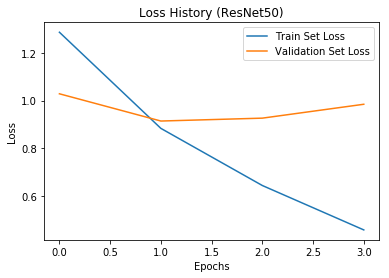

In [11]:
resnet_test_acc = get_test_acc(resnet_model) ## GETTING REST ACC FOR RESNET

print("Test Accuracy on ResNet50: " + str(resnet_test_acc)) ## PRINTING TEST ACC

set_size = np.arange(len(accuracy_tr_resnet))
plt.plot(set_size, losses_tr_resnet, label='Train Set Loss')
plt.plot(set_size, losses_val_resnet, label='Validation Set Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss History (ResNet50)")
plt.legend()
plt.show()

In [12]:
## CLEARING OUT

del resnet_model, losses_tr_resnet, accuracy_tr_resnet, losses_val_resnet, accuracy_val_resnet
torch.cuda.empty_cache()

## TRAINING DENSENET

return_ft_densenet = train_model(densenet_model, criteria, epochs=5, option=1, lr=1e-3, regc=1e-2, transfer=False, lrs=False)
densenet_model, losses_tr_densenet, accuracy_tr_densenet, losses_val_densenet, accuracy_val_densenet = return_ft_densenet
del return_ft_densenet

(Epoch 0) VLoss: 1.081169063762083, VAcc: 0.6119173729823808, TLoss: 1.3096173078455824, TAcc: 0.5301537779628808


(Epoch 1) VLoss: 0.9415042546846099, VAcc: 0.672907838882026, TLoss: 0.9426897316114277, TAcc: 0.668130000939606


(Epoch 2) VLoss: 0.9140497804698298, VAcc: 0.6821239408800157, TLoss: 0.7535110173918677, TAcc: 0.7375954719299965


(Epoch 3) VLoss: 0.9191949716058828, VAcc: 0.6920021186440678, TLoss: 0.6054911883587533, TAcc: 0.7915530096554587


(Epoch 4) VLoss: 0.9634218529119329, VAcc: 0.6853019069817107, TLoss: 0.4945275031083019, TAcc: 0.832923599760583


**Plot the training and validation losses versus number of iterations or epochs for DenseNet121 on the same plot and obtain test accuracy**

Test Accuracy on DenseNet121: 0.6807108626198083


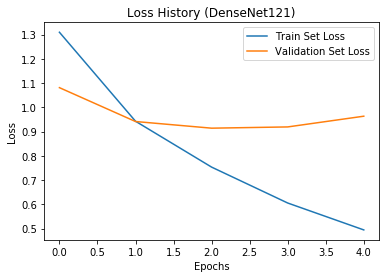

In [13]:
densenet_test_acc = get_test_acc(densenet_model) ## GETTING REST ACC FOR RESNET

print("Test Accuracy on DenseNet121: " + str(densenet_test_acc)) ## PRINTING TEST ACC

set_size = np.arange(len(accuracy_tr_densenet))
plt.plot(set_size, losses_tr_densenet, label='Train Set Loss')
plt.plot(set_size, losses_val_densenet, label='Validation Set Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss History (DenseNet121)")
plt.legend()
plt.show()

In [14]:
## CLEARING OUT

del densenet_model, losses_tr_densenet, accuracy_tr_densenet, losses_val_densenet, accuracy_val_densenet
torch.cuda.empty_cache()

In [15]:
class YourModel(nn.Module): ## Custom defined model
    def __init__(self, bnorm=True, dropout=True):
        # TO DO: Your neural network design
        super(YourModel, self).__init__()
        
        self.bnorm = bnorm
        self.dropout = dropout
        
        self.dropoutl = nn.Dropout(0.25)
        
        self.conv1 = nn.Conv2d(3, 96, 11, 4)
        self.c1bn = nn.BatchNorm2d(96)
        
        self.conv2 = nn.Conv2d(96, 256, 11, 1)
        self.c2bn = nn.BatchNorm2d(256)
        
        
        self.conv3 = nn.Conv2d(256, 384, 3, 1)
        self.c3bn = nn.BatchNorm2d(384)  

        self.conv4 = nn.Conv2d(384, 384, 3, 1)
        self.c4bn = nn.BatchNorm2d(384) 

        self.conv5 = nn.Conv2d(384, 256, 3, 1)
        self.c5bn = nn.BatchNorm2d(256) 
        
        self.fc1 = nn.Linear(1024, 256)
        self.fc1bn = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 128)
        self.fc2bn = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 8)
        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        torch.nn.init.xavier_uniform_(self.conv5.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        
        x = self.conv1(x)
        if self.bnorm:
            x = self.c1bn(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = self.conv2(x)
        if self.bnorm:
            x = self.c2bn(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(x)
        if self.dropout:
            x = self.dropoutl(x)
 
        x = self.conv3(x)
        if self.bnorm:
            x = self.c3bn(x)
        x = F.relu(x)
        if self.dropout:
            x = self.dropoutl(x)

        x = self.conv4(x)
        if self.bnorm:
            x = self.c4bn(x)
        x = F.relu(x)
        if self.dropout:
            x = self.dropoutl(x)

        x = self.conv5(x)
        if self.bnorm:
            x = self.c5bn(x)
        x = F.relu(x)
        if self.dropout:
            x = self.dropoutl(x)
            
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        if self.bnorm:
            x = self.fc1bn(x)
        x = F.relu(x)
        if self.dropout:
            x = self.dropoutl(x)
        
        x = self.fc2(x)
        if self.bnorm:
            x = self.fc2bn(x)
        x = F.relu(x)
        if self.dropout:
            x = self.dropoutl(x)
        
        output = self.fc3(x)
        
        return output

In [16]:
## TRAINING A SUPERIOR MODEL (EVERYTHING ON)

mymodel = YourModel(bnorm=True, dropout=True)

criteria = nn.CrossEntropyLoss()

return_ft_mymodel = train_model(mymodel, criteria, epochs=65, option=2, lr=1e-4, regc=1e-2, transfer=False, optimizer="adam", lrs=True)
mymodel, losses_tr_mymodel, accuracy_tr_mymodel, losses_val_mymodel, accuracy_val_mymodel = return_ft_mymodel
del return_ft_mymodel

(Epoch 0) VLoss: 1.9043112831600641, VAcc: 0.2747086864911904, TLoss: 2.150875245594809, TAcc: 0.20396378887883315


(Epoch 1) VLoss: 1.8556162068399333, VAcc: 0.2981991525423729, TLoss: 1.9842979522461588, TAcc: 0.2563858201529117


(Epoch 2) VLoss: 1.8138388455924341, VAcc: 0.3142213983050847, TLoss: 1.9166930897016052, TAcc: 0.27945137753131544


(Epoch 3) VLoss: 1.7804902589927285, VAcc: 0.3248411017012293, TLoss: 1.873206785553736, TAcc: 0.29934874523616006


(Epoch 4) VLoss: 1.7489671929407928, VAcc: 0.34459745763974675, TLoss: 1.835460827705708, TAcc: 0.3141633706312653


(Epoch 5) VLoss: 1.725330720513554, VAcc: 0.35084745767763104, TLoss: 1.8119027851321172, TAcc: 0.3236776004869042


(Epoch 6) VLoss: 1.7061170773991083, VAcc: 0.36061970340245864, TLoss: 1.7914616909432919, TAcc: 0.332702536828129


(Epoch 7) VLoss: 1.691948535078663, VAcc: 0.370577330558987, TLoss: 1.7698334857927147, TAcc: 0.3381927395966036


(Epoch 8) VLoss: 1.6805450744548087, VAcc: 0.371398305110002, TLoss: 1.7539740173529226, TAcc: 0.34637093108596534


(Epoch 9) VLoss: 1.6680098428564556, VAcc: 0.3848252119654316, TLoss: 1.7401300342370432, TAcc: 0.35341255229415625


(Epoch 10) VLoss: 1.648344617778972, VAcc: 0.38694385603322823, TLoss: 1.7264770362394075, TAcc: 0.3612946672219757


(Epoch 11) VLoss: 1.6314949969113883, VAcc: 0.3988347457627119, TLoss: 1.7089880689661554, TAcc: 0.36622113112016774


(Epoch 12) VLoss: 1.6138695943153512, VAcc: 0.40799788145695703, TLoss: 1.6891776972628654, TAcc: 0.37709867704844646


(Epoch 13) VLoss: 1.5986985261157407, VAcc: 0.4181673728813559, TLoss: 1.6727294862693083, TAcc: 0.3861423668286479


(Epoch 14) VLoss: 1.5866956114768982, VAcc: 0.4175847458132243, TLoss: 1.6572952289107843, TAcc: 0.3930242998802915


(Epoch 15) VLoss: 1.5756652526936288, VAcc: 0.4252383474071147, TLoss: 1.6397992653204194, TAcc: 0.4006359110909996


(Epoch 16) VLoss: 1.5635889182656497, VAcc: 0.42767478828713046, TLoss: 1.624059985039082, TAcc: 0.40750136392336367


(Epoch 17) VLoss: 1.554473134420686, VAcc: 0.43355402552475364, TLoss: 1.608242779758805, TAcc: 0.4170172986409343


(Epoch 18) VLoss: 1.5408930960348097, VAcc: 0.43893008489729995, TLoss: 1.5906256234392206, TAcc: 0.42451013821236633


(Epoch 19) VLoss: 1.5367494498269032, VAcc: 0.4443326271691565, TLoss: 1.5789261116203688, TAcc: 0.43010774690208703


(Epoch 20) VLoss: 1.520353499105421, VAcc: 0.45029131360983443, TLoss: 1.5612552984386472, TAcc: 0.4368010093134346


(Epoch 21) VLoss: 1.518162143432488, VAcc: 0.45137711879560505, TLoss: 1.55231941828491, TAcc: 0.4409108474322245


(Epoch 22) VLoss: 1.5014024427381611, VAcc: 0.4638506355932203, TLoss: 1.5303205809694655, TAcc: 0.45384899530004946


(Epoch 23) VLoss: 1.496503906734919, VAcc: 0.4650158899820457, TLoss: 1.5187271699837759, TAcc: 0.45860951995173244


(Epoch 24) VLoss: 1.4832655686443135, VAcc: 0.46567796625323216, TLoss: 1.5023898630277486, TAcc: 0.4676157028962534


(Epoch 25) VLoss: 1.469923668998783, VAcc: 0.4721133476596768, TLoss: 1.4783344671235863, TAcc: 0.47646503913487104


(Epoch 26) VLoss: 1.4708709454132338, VAcc: 0.47547669506679147, TLoss: 1.4674418297219785, TAcc: 0.48466709856445905


(Epoch 27) VLoss: 1.4612352726823192, VAcc: 0.48559322044000786, TLoss: 1.450374168876215, TAcc: 0.49078241502139586


(Epoch 28) VLoss: 1.448718169988212, VAcc: 0.4908898306094994, TLoss: 1.4315658268353617, TAcc: 0.49906971725166266


(Epoch 29) VLoss: 1.4441095237004555, VAcc: 0.48776483081154903, TLoss: 1.4079487523288592, TAcc: 0.5105473722549195


(Epoch 30) VLoss: 1.4298355316711684, VAcc: 0.4959480934223886, TLoss: 1.3895477817413655, TAcc: 0.5193904573613025


(Epoch 31) VLoss: 1.424514973567704, VAcc: 0.5019597459142491, TLoss: 1.3758159559669223, TAcc: 0.5238799100226544


(Epoch 32) VLoss: 1.4218117291644468, VAcc: 0.5002383476091643, TLoss: 1.349992020755795, TAcc: 0.5325581924289676


(Epoch 33) VLoss: 1.4177050065186063, VAcc: 0.5020391951173039, TLoss: 1.327752348463586, TAcc: 0.5436431623942463


(Epoch 34) VLoss: 1.4134425945201163, VAcc: 0.5029131355932204, TLoss: 1.3061754466794062, TAcc: 0.5524055510125262


(Epoch 35) VLoss: 1.408152186264426, VAcc: 0.5083951273206937, TLoss: 1.2827490757543145, TAcc: 0.5631609156622109


(Epoch 36) VLoss: 1.4003056580737485, VAcc: 0.5080773305084746, TLoss: 1.2638976391325605, TAcc: 0.5697496136029562


(Epoch 37) VLoss: 1.3975487513057256, VAcc: 0.5113082629139141, TLoss: 1.2408204762648183, TAcc: 0.5777709583864145


(Epoch 38) VLoss: 1.4021438178369554, VAcc: 0.5140625001010248, TLoss: 1.2117071472161205, TAcc: 0.5915120931381875


(Epoch 39) VLoss: 1.393338045831454, VAcc: 0.514804025575266, TLoss: 1.1930883131974133, TAcc: 0.6019145526784532


(Epoch 40) VLoss: 1.4029474793854406, VAcc: 0.5140095337972803, TLoss: 1.1716904316388124, TAcc: 0.6072780278557581


(Epoch 41) VLoss: 1.3956145300703533, VAcc: 0.5111493645078045, TLoss: 1.1460725775847198, TAcc: 0.6163552464322841


(Epoch 42) VLoss: 1.4039781608824002, VAcc: 0.5177701272196689, TLoss: 1.1240236664494725, TAcc: 0.6229155301202274


(Epoch 43) VLoss: 1.3869121620210552, VAcc: 0.5150158900325581, TLoss: 1.1032497964006789, TAcc: 0.6332389980343217


(Epoch 44) VLoss: 1.3854462160902508, VAcc: 0.5180614408800157, TLoss: 1.08276211209331, TAcc: 0.6418809101936666


(Epoch 45) VLoss: 1.381232677374856, VAcc: 0.5246027543888254, TLoss: 1.0563718488875855, TAcc: 0.65101836699966


(Epoch 46) VLoss: 1.3932809526637449, VAcc: 0.518299788236618, TLoss: 1.038197724616274, TAcc: 0.6572763229938263


(Epoch 47) VLoss: 1.3982088919413291, VAcc: 0.5190413137108593, TLoss: 1.0077003527194897, TAcc: 0.6694217130647483


(Epoch 48) VLoss: 1.4019139621217371, VAcc: 0.5197828391851005, TLoss: 0.9911964166248943, TAcc: 0.6744652436980119


(Epoch 49) VLoss: 1.3959823301282979, VAcc: 0.524046610472566, TLoss: 0.9723440708843529, TAcc: 0.6813409256596937


(Epoch 50) VLoss: 1.4074006191754744, VAcc: 0.5206832628128892, TLoss: 0.9465943475141593, TAcc: 0.6921104973935066


(Epoch 51) VLoss: 1.412332944950815, VAcc: 0.5241260594230587, TLoss: 0.9324245579699253, TAcc: 0.6969022777063627


(Epoch 52) VLoss: 1.4165538529218253, VAcc: 0.5273834744752464, TLoss: 0.914543040424374, TAcc: 0.7033756137739682


(Epoch 53) VLoss: 1.4161910121723758, VAcc: 0.5261387713884903, TLoss: 0.8978672652379841, TAcc: 0.7102319740234537


(Epoch 54) VLoss: 1.4185061899282165, VAcc: 0.5268008476596767, TLoss: 0.8797367061283572, TAcc: 0.7171735770313452


(Epoch 55) VLoss: 1.4066944465798847, VAcc: 0.53125, TLoss: 0.8585992612314562, TAcc: 0.7218943217121963


(Epoch 56) VLoss: 1.4315400790360013, VAcc: 0.5225635595240835, TLoss: 0.8328898795107578, TAcc: 0.7330804464664865


(Epoch 57) VLoss: 1.4305877402677374, VAcc: 0.5263506355932204, TLoss: 0.8229245289843133, TAcc: 0.7361372522428526


(Epoch 58) VLoss: 1.4379674347780518, VAcc: 0.5245233051857706, TLoss: 0.8019550907273665, TAcc: 0.7445007046909197


(Epoch 59) VLoss: 1.428964954816689, VAcc: 0.5299523306094994, TLoss: 0.7885850498439573, TAcc: 0.7457622977013284


(Epoch 60) VLoss: 1.4432818667363312, VAcc: 0.5301112290156089, TLoss: 0.773337105783165, TAcc: 0.7533454946592344


(Epoch 61) VLoss: 1.4517565859576402, VAcc: 0.530217161117974, TLoss: 0.7596093649137104, TAcc: 0.7596523231648384


(Epoch 62) VLoss: 1.4488049886994443, VAcc: 0.5330508477607016, TLoss: 0.746722837162356, TAcc: 0.7624244180976921


(Epoch 63) VLoss: 1.4768390559543998, VAcc: 0.5196504239308632, TLoss: 0.7258765069305474, TAcc: 0.7717533869946257


(Epoch 64) VLoss: 1.4722373167336997, VAcc: 0.527542372881356, TLoss: 0.7148402110904667, TAcc: 0.7762178350847664


### BatchNorm Comparison

**Create two models one with batchnorm layers and one without batchnorm layers**


In [17]:
## TRAINING A MODEL (BN OFF)

model_bnoff = YourModel(bnorm=False, dropout=True)

criteria = nn.CrossEntropyLoss()

return_ft_model_bnoff = train_model(model_bnoff, criteria, epochs=65, option=2, lr=1e-4, regc=1e-2, transfer=False, optimizer="adam", lrs=True)
model_bnoff, losses_tr_model_bnoff, accuracy_tr_model_bnoff, losses_val_model_bnoff, accuracy_val_model_bnoff = return_ft_model_bnoff
del return_ft_model_bnoff

(Epoch 0) VLoss: 1.9758403664928372, VAcc: 0.23580508489729995, TLoss: 2.4816061603262067, TAcc: 0.20626079742367387


(Epoch 1) VLoss: 1.964163326610953, VAcc: 0.23485169496576666, TLoss: 1.9809631251274271, TAcc: 0.2201871931341523


(Epoch 2) VLoss: 1.9445971836478024, VAcc: 0.23707627113592827, TLoss: 1.9628652459340739, TAcc: 0.2299452173160323


(Epoch 3) VLoss: 1.926053556345277, VAcc: 0.26091101696178065, TLoss: 1.945943568446112, TAcc: 0.24325104565062422


(Epoch 4) VLoss: 1.8948643894518835, VAcc: 0.28074682204021234, TLoss: 1.923602676729784, TAcc: 0.26593642027665537


(Epoch 5) VLoss: 1.8712440395759324, VAcc: 0.2905455508537717, TLoss: 1.9000776779567097, TAcc: 0.28066068832755936


(Epoch 6) VLoss: 1.8534827787997359, VAcc: 0.29663665254868693, TLoss: 1.882669089026485, TAcc: 0.28767048555908475


(Epoch 7) VLoss: 1.8011402113962982, VAcc: 0.32404661017580555, TLoss: 1.8554420352827572, TAcc: 0.3006501182174006


(Epoch 8) VLoss: 1.7656182343676938, VAcc: 0.34126059322665303, TLoss: 1.8156088230457712, TAcc: 0.3221040189266205


(Epoch 9) VLoss: 1.7333794923151953, VAcc: 0.3518802966227976, TLoss: 1.7816937806758475, TAcc: 0.3357451355203669


(Epoch 10) VLoss: 1.7017531687930478, VAcc: 0.3712658898557647, TLoss: 1.7496552714219331, TAcc: 0.3505535097409647


(Epoch 11) VLoss: 1.680817564665261, VAcc: 0.3783368644130937, TLoss: 1.7178834455233094, TAcc: 0.36470778778935153


(Epoch 12) VLoss: 1.654238102799755, VAcc: 0.3944385593472901, TLoss: 1.6796934587735657, TAcc: 0.3810022277189485


(Epoch 13) VLoss: 1.6310522233025502, VAcc: 0.40349576281288924, TLoss: 1.6371107505568376, TAcc: 0.404249636332194


(Epoch 14) VLoss: 1.6137615321046215, VAcc: 0.41615466104220533, TLoss: 1.5940990236634058, TAcc: 0.41670076377848364


(Epoch 15) VLoss: 1.5966572397846286, VAcc: 0.4245233050847458, TLoss: 1.5409545389473016, TAcc: 0.4395606019395463


(Epoch 16) VLoss: 1.5823294692120309, VAcc: 0.4369703389830508, TLoss: 1.482673814110722, TAcc: 0.46814136661536304


(Epoch 17) VLoss: 1.568756374262147, VAcc: 0.4450211864659342, TLoss: 1.4262358070265317, TAcc: 0.49107053558877173


(Epoch 18) VLoss: 1.5773428648205128, VAcc: 0.45103283908407565, TLoss: 1.3655601487092093, TAcc: 0.517254841792668


(Epoch 19) VLoss: 1.5698708497871787, VAcc: 0.45447563569424515, TLoss: 1.3084965479289385, TAcc: 0.542077536828129


(Epoch 20) VLoss: 1.5782170507867457, VAcc: 0.4557733050847458, TLoss: 1.248152568830666, TAcc: 0.5649748818248722


(Epoch 21) VLoss: 1.6024123804043915, VAcc: 0.45606461874509263, TLoss: 1.18353916837814, TAcc: 0.5897356337689339


(Epoch 22) VLoss: 1.6106342834941412, VAcc: 0.4684322034403429, TLoss: 1.1231268903887863, TAcc: 0.6110537143463785


(Epoch 23) VLoss: 1.643027834973093, VAcc: 0.4623146185935554, TLoss: 1.0691745107055557, TAcc: 0.631204537212426


(Epoch 24) VLoss: 1.6556853237798659, VAcc: 0.4646980931698266, TLoss: 1.0150231174543394, TAcc: 0.6511354337347315


(Epoch 25) VLoss: 1.6777048858545593, VAcc: 0.46615466096643676, TLoss: 0.967762103148386, TAcc: 0.6693091925999797


(Epoch 26) VLoss: 1.6897318060115232, VAcc: 0.4713983050847458, TLoss: 0.9233591283889527, TAcc: 0.6847381342387369


(Epoch 27) VLoss: 1.723334971120802, VAcc: 0.46978283913458807, TLoss: 0.8849531152569656, TAcc: 0.6970085470388967


(Epoch 28) VLoss: 1.766315813791954, VAcc: 0.4686705507969452, TLoss: 0.8457513989708948, TAcc: 0.7108303782787729


(Epoch 29) VLoss: 1.7769060064170321, VAcc: 0.46684322038949544, TLoss: 0.8107440609881218, TAcc: 0.7270884479191286


(Epoch 30) VLoss: 1.7963419788974826, VAcc: 0.4675582627118644, TLoss: 0.782612122584742, TAcc: 0.7354945217463987


(Epoch 31) VLoss: 1.8271044108827235, VAcc: 0.473172669441013, TLoss: 0.7431400175212969, TAcc: 0.7485582606166813


(Epoch 32) VLoss: 1.8356934583793252, VAcc: 0.47147775428780053, TLoss: 0.7301346517201011, TAcc: 0.7535353018882427


(Epoch 33) VLoss: 1.8747823915239108, VAcc: 0.4720074153047497, TLoss: 0.6956044944888311, TAcc: 0.7671292507902104


(Epoch 34) VLoss: 1.9058568063428847, VAcc: 0.47243114421933385, TLoss: 0.6716725515135636, TAcc: 0.7753534733826387


(Epoch 35) VLoss: 1.9050190337633683, VAcc: 0.47023305094848245, TLoss: 0.654356438555616, TAcc: 0.7785432578824091


(Epoch 36) VLoss: 1.9563059443134372, VAcc: 0.4766949152542373, TLoss: 0.6358237428868071, TAcc: 0.7885166621377282


(Epoch 37) VLoss: 1.9710287178977062, VAcc: 0.4781514830508475, TLoss: 0.6228001631320791, TAcc: 0.7929191671364696


(Epoch 38) VLoss: 1.9620040776365895, VAcc: 0.4720074153047497, TLoss: 0.5952328545404664, TAcc: 0.8034892707851762


(Epoch 39) VLoss: 2.0254047351368403, VAcc: 0.4763771186945802, TLoss: 0.5769537105205211, TAcc: 0.8085566694009388


(Epoch 40) VLoss: 2.0172301631862832, VAcc: 0.47409957622067406, TLoss: 0.5607979788213757, TAcc: 0.8143935261043251


(Epoch 41) VLoss: 2.002504434625981, VAcc: 0.4761387713379779, TLoss: 0.5533910221030526, TAcc: 0.8168695444756365


(Epoch 42) VLoss: 2.0742281958208246, VAcc: 0.4765095339488175, TLoss: 0.5368412333177337, TAcc: 0.8218181714943961


(Epoch 43) VLoss: 2.035812050609265, VAcc: 0.4763506355427079, TLoss: 0.5262875730686999, TAcc: 0.8275584197213464


(Epoch 44) VLoss: 2.0607193304320512, VAcc: 0.4783633475081395, TLoss: 0.5401454656682116, TAcc: 0.826635524651683


(Epoch 45) VLoss: 2.0511481246705783, VAcc: 0.47492055089797003, TLoss: 0.5022930727994188, TAcc: 0.8356337516020376


(Epoch 46) VLoss: 2.0916152091349587, VAcc: 0.47690677971152934, TLoss: 0.48751807284693344, TAcc: 0.8411523686233142


(Epoch 47) VLoss: 2.113034585774955, VAcc: 0.47915783903356324, TLoss: 0.47162611406322913, TAcc: 0.8453792735194483


(Epoch 48) VLoss: 2.1113983160358365, VAcc: 0.47489406774609777, TLoss: 0.47380116751008, TAcc: 0.8439784506534008


(Epoch 49) VLoss: 2.127727462073504, VAcc: 0.47460275433831295, TLoss: 0.461206221665051, TAcc: 0.8505052055027468


(Epoch 50) VLoss: 2.107670539516514, VAcc: 0.4752913135088096, TLoss: 0.4555557040035302, TAcc: 0.8526186579508139


(Epoch 51) VLoss: 2.113344928975833, VAcc: 0.47595338977999607, TLoss: 0.4458264742548584, TAcc: 0.8560522367768254


(Epoch 52) VLoss: 2.1496342683242537, VAcc: 0.47952860164440286, TLoss: 0.434267240044073, TAcc: 0.8590965402887223


(Epoch 53) VLoss: 2.1538514414076078, VAcc: 0.4768802965596571, TLoss: 0.43354744750557217, TAcc: 0.8589271913183496


(Epoch 54) VLoss: 2.1647639011932633, VAcc: 0.479952330558987, TLoss: 0.4227240024623296, TAcc: 0.8645122977013283


(Epoch 55) VLoss: 2.1625962025028165, VAcc: 0.4773040254742412, TLoss: 0.41674305880112006, TAcc: 0.8664183260701227


(Epoch 56) VLoss: 2.203345921079991, VAcc: 0.4798199153047497, TLoss: 0.40234464756774563, TAcc: 0.8726416166792524


(Epoch 57) VLoss: 2.168384644944789, VAcc: 0.47481461879560505, TLoss: 0.4071090831190136, TAcc: 0.8706895572073916


(Epoch 58) VLoss: 2.185782991223416, VAcc: 0.4738612288640717, TLoss: 0.3974193232173615, TAcc: 0.8729041644021974


(Epoch 59) VLoss: 2.2096193453012885, VAcc: 0.4677701271691565, TLoss: 0.412698436142705, TAcc: 0.8670673076988112


(Epoch 60) VLoss: 2.1845124333591786, VAcc: 0.4721133474071147, TLoss: 0.39677891921489794, TAcc: 0.8716044962828886


(Epoch 61) VLoss: 2.235508498498949, VAcc: 0.4755561440172842, TLoss: 0.3711095188949125, TAcc: 0.8814432169528718


(Epoch 62) VLoss: 2.205547828795546, VAcc: 0.47489406774609777, TLoss: 0.384954992539071, TAcc: 0.8767003091514534


(Epoch 63) VLoss: 2.269441624819222, VAcc: 0.4680084745257588, TLoss: 0.3682520675743725, TAcc: 0.8813483133383676


(Epoch 64) VLoss: 2.2243892964670215, VAcc: 0.47460275433831295, TLoss: 0.37091568433646616, TAcc: 0.8791842835169312


**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

Model with BatchNorm
---------------
Test Accuracy on Model (w/ BN): 0.5291533546325878


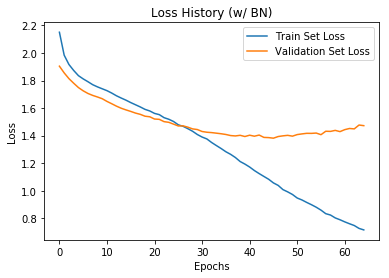

Model without BatchNorm
---------------
Test Accuracy on Model (w/o BN): 0.47424121405750796


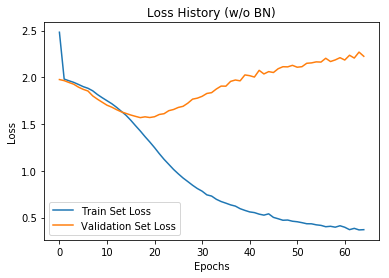

In [18]:
print("Model with BatchNorm\n---------------")

mymodel_test_acc = get_test_acc(mymodel) ## GETTING REST ACC FOR MY MODEL w/ BN
print("Test Accuracy on Model (w/ BN): " + str(mymodel_test_acc)) ## PRINTING TEST ACC

set_size = np.arange(len(accuracy_tr_mymodel))
plt.plot(set_size, losses_tr_mymodel, label='Train Set Loss')
plt.plot(set_size, losses_val_mymodel, label='Validation Set Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss History (w/ BN)")
plt.legend()
plt.show()

print("Model without BatchNorm\n---------------")

model_bnoff_test_acc = get_test_acc(model_bnoff) ## GETTING REST ACC FOR MY MODEL w/o BN
print("Test Accuracy on Model (w/o BN): " + str(model_bnoff_test_acc)) ## PRINTING TEST ACC

set_size = np.arange(len(accuracy_tr_model_bnoff))
plt.plot(set_size, losses_tr_model_bnoff, label='Train Set Loss')
plt.plot(set_size, losses_val_model_bnoff, label='Validation Set Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss History (w/o BN)")
plt.legend()
plt.show()

In [19]:
## CLEARING OUT

del model_bnoff, losses_tr_model_bnoff, accuracy_tr_model_bnoff, losses_val_model_bnoff, accuracy_val_model_bnoff
torch.cuda.empty_cache()

### Dropout Comparison

**Create two models one with dropout layers and one without dropout layers**


In [20]:
## TRAINING A MODEL (DROP OFF)

model_droff = YourModel(bnorm=True, dropout=False)

criteria = nn.CrossEntropyLoss()

return_ft_model_droff = train_model(model_droff, criteria, epochs=65, option=2, lr=1e-4, regc=1e-2, transfer=False, optimizer="adam", lrs=True)
model_droff, losses_tr_model_droff, accuracy_tr_model_droff, losses_val_model_droff, accuracy_val_model_droff = return_ft_model_droff
del return_ft_model_droff

(Epoch 0) VLoss: 1.7797475719856004, VAcc: 0.32629766949783945, TLoss: 1.8836054636231552, TAcc: 0.2954594017131954


(Epoch 1) VLoss: 1.7169249209307007, VAcc: 0.357521186440678, TLoss: 1.7702691864460072, TAcc: 0.3374897708706822


(Epoch 2) VLoss: 1.6711009033655717, VAcc: 0.38217690688068584, TLoss: 1.7124327911552808, TAcc: 0.3640747181489958


(Epoch 3) VLoss: 1.6222849558975736, VAcc: 0.4026747881355932, TLoss: 1.658074664900489, TAcc: 0.38757558194458064


(Epoch 4) VLoss: 1.5883500858888788, VAcc: 0.41490995757660626, TLoss: 1.6079546911496643, TAcc: 0.40962277232332434


(Epoch 5) VLoss: 1.5571482868517859, VAcc: 0.43575211879560505, TLoss: 1.5568641703179542, TAcc: 0.43407665030330633


(Epoch 6) VLoss: 1.5287299469365911, VAcc: 0.4474046611684864, TLoss: 1.5029640442936132, TAcc: 0.46026720768171


(Epoch 7) VLoss: 1.501788653559604, VAcc: 0.45397245757660626, TLoss: 1.4375634367584336, TAcc: 0.4844153482863244


(Epoch 8) VLoss: 1.4894817582631514, VAcc: 0.4720603813559322, TLoss: 1.3652627393709007, TAcc: 0.5171838061606631


(Epoch 9) VLoss: 1.4665481407763594, VAcc: 0.47923728823661804, TLoss: 1.2842947562535605, TAcc: 0.5484383524309658


(Epoch 10) VLoss: 1.4687865053193043, VAcc: 0.48792372896509656, TLoss: 1.1922977946328779, TAcc: 0.5860980405875131


(Epoch 11) VLoss: 1.4859407069319386, VAcc: 0.48697033903356324, TLoss: 1.0894629751536864, TAcc: 0.6289313966500844


(Epoch 12) VLoss: 1.5028673279083382, VAcc: 0.4913135592715215, TLoss: 0.9798682240729636, TAcc: 0.6721239089120364


(Epoch 13) VLoss: 1.5223980768252228, VAcc: 0.4854343220338983, TLoss: 0.8832895046430277, TAcc: 0.7100370522086502


(Epoch 14) VLoss: 1.5537163382869656, VAcc: 0.4907309322033898, TLoss: 0.7755334362493339, TAcc: 0.752344744509839


(Epoch 15) VLoss: 1.5925073300377797, VAcc: 0.4876853813559322, TLoss: 0.6875979885564628, TAcc: 0.7845273004356006


(Epoch 16) VLoss: 1.6264943005674977, VAcc: 0.4819915254237288, TLoss: 0.6133884863227818, TAcc: 0.8125176168502646


(Epoch 17) VLoss: 1.662795328487784, VAcc: 0.48103813574475757, TLoss: 0.5503982962868738, TAcc: 0.8368004409979422


(Epoch 18) VLoss: 1.7031903408341489, VAcc: 0.47693326286340165, TLoss: 0.49115754695648844, TAcc: 0.8564210538323044


(Epoch 19) VLoss: 1.703226854235439, VAcc: 0.47796610174542764, TLoss: 0.45136924914434445, TAcc: 0.8715237997947856


(Epoch 20) VLoss: 1.7429400662244376, VAcc: 0.4759004237288136, TLoss: 0.4247696470495657, TAcc: 0.8806231814918789


(Epoch 21) VLoss: 1.767418505781788, VAcc: 0.472960805236283, TLoss: 0.38361552721219705, TAcc: 0.8941665530204773


(Epoch 22) VLoss: 1.760118697659444, VAcc: 0.4728283899820457, TLoss: 0.3762113555631739, TAcc: 0.8954946353925881


(Epoch 23) VLoss: 1.7841649277735565, VAcc: 0.4713983050847458, TLoss: 0.3575563333770062, TAcc: 0.9035318921643791


(Epoch 24) VLoss: 1.7941496432837793, VAcc: 0.4720074153047497, TLoss: 0.3393784823147118, TAcc: 0.9105149800050343


(Epoch 25) VLoss: 1.795184654704595, VAcc: 0.47486758484678754, TLoss: 0.3307660759340787, TAcc: 0.9126869658206371


(Epoch 26) VLoss: 1.8006832569332447, VAcc: 0.4639830508474576, TLoss: 0.32445488929325805, TAcc: 0.9149095290096093


(Epoch 27) VLoss: 1.8159091482728213, VAcc: 0.45971927981255417, TLoss: 0.31581078637787635, TAcc: 0.9172809829103186


(Epoch 28) VLoss: 1.8214816269228014, VAcc: 0.45813029676170675, TLoss: 0.3074067396792114, TAcc: 0.9198217857814004


(Epoch 29) VLoss: 1.8453740911968683, VAcc: 0.4555614406274537, TLoss: 0.28233640632519486, TAcc: 0.9283261729470381


(Epoch 30) VLoss: 1.8557129128504608, VAcc: 0.46228813569424515, TLoss: 0.3000285441042684, TAcc: 0.9210566694009389


(Epoch 31) VLoss: 1.8562126371820094, VAcc: 0.460010593220339, TLoss: 0.29609686734405816, TAcc: 0.9229041644021975


(Epoch 32) VLoss: 1.8578585345866316, VAcc: 0.4593485169491525, TLoss: 0.27119983815132304, TAcc: 0.9331798963512935


(Epoch 33) VLoss: 1.8800036139407401, VAcc: 0.45429025438882537, TLoss: 0.260171787504186, TAcc: 0.9367765730154429


(Epoch 34) VLoss: 1.8975609662169117, VAcc: 0.4463718220338983, TLoss: 0.2841330484823978, TAcc: 0.92658153755445


(Epoch 35) VLoss: 1.9043295777450173, VAcc: 0.4469014830508475, TLoss: 0.267898497064697, TAcc: 0.9322126750404953


(Epoch 36) VLoss: 1.899174018431518, VAcc: 0.4476165253732164, TLoss: 0.2663093848272841, TAcc: 0.9328838197897512


(Epoch 37) VLoss: 1.9135680703793543, VAcc: 0.44819915269391014, TLoss: 0.244276081638556, TAcc: 0.9414751545757266


(Epoch 38) VLoss: 1.93537716037136, VAcc: 0.4492849576271186, TLoss: 0.2556686489770176, TAcc: 0.9348341743996803


(Epoch 39) VLoss: 1.9437224026453697, VAcc: 0.44271716096643676, TLoss: 0.25633544573124417, TAcc: 0.9352126523112574


(Epoch 40) VLoss: 1.9409099413176714, VAcc: 0.43858580518577056, TLoss: 0.2489616318691707, TAcc: 0.9373829332649285


(Epoch 41) VLoss: 1.9758513832496385, VAcc: 0.434004237338648, TLoss: 0.23209453144289077, TAcc: 0.9433226495769852


(Epoch 42) VLoss: 1.9933516251838814, VAcc: 0.4359904661522073, TLoss: 0.2529614165002573, TAcc: 0.934686988549875


(Epoch 43) VLoss: 2.017481650336314, VAcc: 0.4378177965596571, TLoss: 0.224962816762586, TAcc: 0.9444972949670561


(Epoch 44) VLoss: 2.027247643066665, VAcc: 0.43122351699966494, TLoss: 0.2428850716944282, TAcc: 0.9370061602152832


(Epoch 45) VLoss: 2.020508410566944, VAcc: 0.4351959746267836, TLoss: 0.23050859704719368, TAcc: 0.9420513957104785


(Epoch 46) VLoss: 2.0382497846069985, VAcc: 0.4308262712369531, TLoss: 0.21711203110873276, TAcc: 0.9461879432624114


(Epoch 47) VLoss: 2.0725793737476157, VAcc: 0.424443855881691, TLoss: 0.22142169789959354, TAcc: 0.9435141616679252


(Epoch 48) VLoss: 2.0764348102828203, VAcc: 0.4269067796610169, TLoss: 0.2451251543794118, TAcc: 0.9363111474835281


(Epoch 49) VLoss: 2.056202425795086, VAcc: 0.43040254232236896, TLoss: 0.22628735282742385, TAcc: 0.9420974268135449


(Epoch 50) VLoss: 2.075621042211177, VAcc: 0.4278866524918605, TLoss: 0.20556144302195692, TAcc: 0.9481240907459394


(Epoch 51) VLoss: 2.0778953281499573, VAcc: 0.4347192796610169, TLoss: 0.22760037831592222, TAcc: 0.9404778141501947


(Epoch 52) VLoss: 2.0960974814528126, VAcc: 0.42460275428780053, TLoss: 0.21690028646419235, TAcc: 0.9416967857814004


(Epoch 53) VLoss: 2.097795052043462, VAcc: 0.42423199167696096, TLoss: 0.19701525484416502, TAcc: 0.9507472949670561


(Epoch 54) VLoss: 2.0949142757108654, VAcc: 0.4292372881861056, TLoss: 0.20054227898412563, TAcc: 0.9490691489361702


(Epoch 55) VLoss: 2.1240267096939736, VAcc: 0.42460275428780053, TLoss: 0.2145450861371578, TAcc: 0.9440097063145739


(Epoch 56) VLoss: 2.141047860606242, VAcc: 0.4205773306094994, TLoss: 0.19437875223497972, TAcc: 0.9505478268819498


(Epoch 57) VLoss: 2.1351728459536017, VAcc: 0.42272245757660626, TLoss: 0.20862548248247897, TAcc: 0.9464857246858854


(Epoch 58) VLoss: 2.1301823803934, VAcc: 0.4193855933213638, TLoss: 0.2039891928962782, TAcc: 0.9471665302912394


(Epoch 59) VLoss: 2.1365699060892656, VAcc: 0.4250000000505124, TLoss: 0.19981868675520234, TAcc: 0.9481843289754069


(Epoch 60) VLoss: 2.117991436336, VAcc: 0.4204449153552621, TLoss: 0.1830065111160701, TAcc: 0.9534148254293077


(Epoch 61) VLoss: 2.16538701118049, VAcc: 0.42033898300033506, TLoss: 0.18638945468668397, TAcc: 0.951855450995425


(Epoch 62) VLoss: 2.162114321175268, VAcc: 0.4181144068301734, TLoss: 0.20832372195226082, TAcc: 0.9438704764589351


(Epoch 63) VLoss: 2.13912057270438, VAcc: 0.4219544492030548, TLoss: 0.18570483873816246, TAcc: 0.952593085106383


(Epoch 64) VLoss: 2.1757748217905983, VAcc: 0.41345338977999607, TLoss: 0.17007012383100834, TAcc: 0.956384683585336


**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

Model with Dropout
---------------
Test Accuracy on Model (w/ DO): 0.5291533546325878


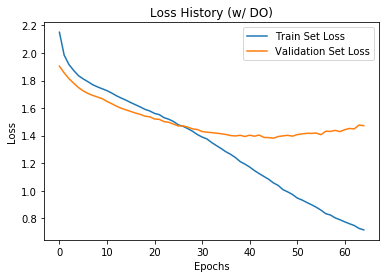

Model without Dropout
---------------
Test Accuracy on Model (w/o DO): 0.4189297124600639


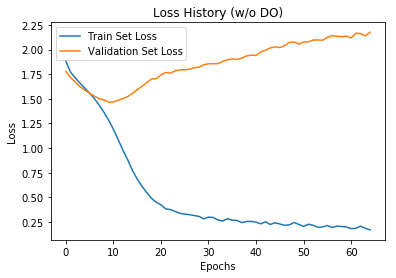

In [21]:
print("Model with Dropout\n---------------")

mymodel_test_acc = get_test_acc(mymodel) ## GETTING REST ACC FOR MY MODEL w/ BN
print("Test Accuracy on Model (w/ DO): " + str(mymodel_test_acc)) ## PRINTING TEST ACC

set_size = np.arange(len(accuracy_tr_mymodel))
plt.plot(set_size, losses_tr_mymodel, label='Train Set Loss')
plt.plot(set_size, losses_val_mymodel, label='Validation Set Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss History (w/ DO)")
plt.legend()
plt.show()

print("Model without Dropout\n---------------")

model_droff_test_acc = get_test_acc(model_droff) ## GETTING REST ACC FOR MY MODEL w/o BN
print("Test Accuracy on Model (w/o DO): " + str(model_droff_test_acc)) ## PRINTING TEST ACC

set_size = np.arange(len(accuracy_tr_model_droff))
plt.plot(set_size, losses_tr_model_droff, label='Train Set Loss')
plt.plot(set_size, losses_val_model_droff, label='Validation Set Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss History (w/o DO)")
plt.legend()
plt.show()

In [22]:
## CLEARING OUT

del model_droff, losses_tr_model_droff, accuracy_tr_model_droff, losses_val_model_droff, accuracy_val_model_droff
torch.cuda.empty_cache()

### Optimizer Comparison

**Optimize two identical models one with SGD+Momentum and one with Adam**


In [23]:
## TRAINING A MODEL (SGDM)

model_sgdm = YourModel(bnorm=True, dropout=True)

criteria = nn.CrossEntropyLoss()

return_ft_model_sgdm = train_model(model_sgdm, criteria, epochs=65, option=2, lr=1e-4, regc=1e-2, transfer=False, optimizer="sgdm", lrs=True)
model_sgdm, losses_tr_model_sgdm, accuracy_tr_model_sgdm, losses_val_model_sgdm, accuracy_val_model_sgdm = return_ft_model_sgdm
del return_ft_model_sgdm

(Epoch 0) VLoss: 2.0508927884748425, VAcc: 0.17902542372881355, TLoss: 2.345557926056233, TAcc: 0.1585214357215462


(Epoch 1) VLoss: 1.9911610979144856, VAcc: 0.22139830508474576, TLoss: 2.2368218308644936, TAcc: 0.1813335379176106


(Epoch 2) VLoss: 1.9621347138437175, VAcc: 0.2399364406779661, TLoss: 2.178148950583546, TAcc: 0.19419439900005964


(Epoch 3) VLoss: 1.935445076328213, VAcc: 0.24994703394881748, TLoss: 2.1444024884108956, TAcc: 0.20672622295558876


(Epoch 4) VLoss: 1.9253580873295413, VAcc: 0.2620497881355932, TLoss: 2.1065263459023007, TAcc: 0.21573070103817799


(Epoch 5) VLoss: 1.9139309242620306, VAcc: 0.26207627119275473, TLoss: 2.078494886810898, TAcc: 0.22132205857452772


(Epoch 6) VLoss: 1.9037009962534501, VAcc: 0.2657574152542373, TLoss: 2.0591770665865416, TAcc: 0.22588936625220252


(Epoch 7) VLoss: 1.8910833132469047, VAcc: 0.2714512711864407, TLoss: 2.030644221508757, TAcc: 0.23564909529601427


(Epoch 8) VLoss: 1.8886214343167969, VAcc: 0.2723781779661017, TLoss: 2.016653196693312, TAcc: 0.23991066557718507


(Epoch 9) VLoss: 1.8784853290703336, VAcc: 0.2751588983050847, TLoss: 1.9983805326705284, TAcc: 0.24209231224888605


(Epoch 10) VLoss: 1.8755032703027887, VAcc: 0.275291313559322, TLoss: 1.9870878015004152, TAcc: 0.250077286785376


(Epoch 11) VLoss: 1.8707311436281366, VAcc: 0.2784692796610169, TLoss: 1.9765651557462436, TAcc: 0.2522049463598441


(Epoch 12) VLoss: 1.8624587847014604, VAcc: 0.28511652543004284, TLoss: 1.961252594501414, TAcc: 0.25810829242493244


(Epoch 13) VLoss: 1.8609492233244038, VAcc: 0.2840307203389831, TLoss: 1.95443504008841, TAcc: 0.26217664577436783


(Epoch 14) VLoss: 1.8596567299406408, VAcc: 0.2838983050847458, TLoss: 1.9414803488034729, TAcc: 0.26608360612646065


(Epoch 15) VLoss: 1.8538535984895996, VAcc: 0.2836334745762712, TLoss: 1.931665595541609, TAcc: 0.2695870840169014


(Epoch 16) VLoss: 1.8508639163890128, VAcc: 0.2862817796610169, TLoss: 1.9220173729226944, TAcc: 0.27393730680147804


(Epoch 17) VLoss: 1.8478634983806286, VAcc: 0.2884004237288136, TLoss: 1.9122588155962896, TAcc: 0.27852961902922774


(Epoch 18) VLoss: 1.8389031573877497, VAcc: 0.2905190677966102, TLoss: 1.9098003453396737, TAcc: 0.28006853520447483


(Epoch 19) VLoss: 1.8323134193986148, VAcc: 0.2970338983113988, TLoss: 1.894940190788702, TAcc: 0.28422269958553587


(Epoch 20) VLoss: 1.8312805123248344, VAcc: 0.3014036017012293, TLoss: 1.8917964794957045, TAcc: 0.2875278459795823


(Epoch 21) VLoss: 1.8283313088497872, VAcc: 0.3023305084808903, TLoss: 1.8839806389301381, TAcc: 0.2918166939459794


(Epoch 22) VLoss: 1.8289767352201172, VAcc: 0.30299258475207674, TLoss: 1.878037968256795, TAcc: 0.2928282415190487


(Epoch 23) VLoss: 1.8215629539247287, VAcc: 0.3059057203452971, TLoss: 1.870305927763594, TAcc: 0.29491782598461663


(Epoch 24) VLoss: 1.8235488927970498, VAcc: 0.30405190678597505, TLoss: 1.862936210463233, TAcc: 0.2977007183200079


(Epoch 25) VLoss: 1.8106328259080142, VAcc: 0.3134533898368225, TLoss: 1.8575756150779994, TAcc: 0.30079105293497127


(Epoch 26) VLoss: 1.8130868804656852, VAcc: 0.3114671610232632, TLoss: 1.8567204390857237, TAcc: 0.29926179761582233


(Epoch 27) VLoss: 1.8153401774875189, VAcc: 0.31080508475207674, TLoss: 1.845396999433531, TAcc: 0.30730701038177977


(Epoch 28) VLoss: 1.811127091868449, VAcc: 0.3146451271249581, TLoss: 1.841728777750164, TAcc: 0.3074098699904503


(Epoch 29) VLoss: 1.8024520217362097, VAcc: 0.316896186446992, TLoss: 1.83483273881547, TAcc: 0.3090658529007688


(Epoch 30) VLoss: 1.8025439826108642, VAcc: 0.31411546610800894, TLoss: 1.8330734251238776, TAcc: 0.31126795783110545


(Epoch 31) VLoss: 1.8012972575123027, VAcc: 0.3161281779787298, TLoss: 1.8288508570786064, TAcc: 0.31252500455007487


(Epoch 32) VLoss: 1.7896807587752908, VAcc: 0.32629766949783945, TLoss: 1.8237017810767424, TAcc: 0.3145037734339423


(Epoch 33) VLoss: 1.779916314755456, VAcc: 0.32643008475207674, TLoss: 1.819342674431226, TAcc: 0.31851188853277385


(Epoch 34) VLoss: 1.7825583239733163, VAcc: 0.327251059334662, TLoss: 1.8086010753685702, TAcc: 0.32361736225743665


(Epoch 35) VLoss: 1.7810346635721497, VAcc: 0.3272245762775005, TLoss: 1.8078318019285269, TAcc: 0.32017753229919055


(Epoch 36) VLoss: 1.7824605733661327, VAcc: 0.32539724577533996, TLoss: 1.8020677554691937, TAcc: 0.32286552102007765


(Epoch 37) VLoss: 1.7758066583487948, VAcc: 0.33228283899567895, TLoss: 1.796636910641447, TAcc: 0.3281181805945457


(Epoch 38) VLoss: 1.782711311922235, VAcc: 0.3260328389893649, TLoss: 1.7956961569211163, TAcc: 0.3310420076475076


(Epoch 39) VLoss: 1.7722705592543393, VAcc: 0.33109110170754336, TLoss: 1.7918236076409089, TAcc: 0.3299116884985714


(Epoch 40) VLoss: 1.7731539344383498, VAcc: 0.33003177967364505, TLoss: 1.7865460018739632, TAcc: 0.3328451764076314


(Epoch 41) VLoss: 1.7731541718466808, VAcc: 0.33185911017580555, TLoss: 1.784067592384122, TAcc: 0.33196206128766353


(Epoch 42) VLoss: 1.7651857430652036, VAcc: 0.332521186446992, TLoss: 1.7809376525540723, TAcc: 0.33410051828580545


(Epoch 43) VLoss: 1.7568174762240911, VAcc: 0.33840042377932594, TLoss: 1.7752591628554866, TAcc: 0.3335305282832883


(Epoch 44) VLoss: 1.7661216733819347, VAcc: 0.3348252119149192, TLoss: 1.7681366075015237, TAcc: 0.3396412984276494


(Epoch 45) VLoss: 1.7561942076278945, VAcc: 0.33744703391093317, TLoss: 1.7664436859441988, TAcc: 0.3390127750575965


(Epoch 46) VLoss: 1.747243820610693, VAcc: 0.3458156780166141, TLoss: 1.7645742172890522, TAcc: 0.34026186580353596


(Epoch 47) VLoss: 1.7488606289281683, VAcc: 0.34184322038949544, TLoss: 1.7617284720671091, TAcc: 0.34391082470298656


(Epoch 48) VLoss: 1.7546204409356845, VAcc: 0.34126059322665303, TLoss: 1.75945127940347, TAcc: 0.34189739045521894


(Epoch 49) VLoss: 1.7441547725160242, VAcc: 0.3451271186566959, TLoss: 1.7534032444581917, TAcc: 0.34473256502591126


(Epoch 50) VLoss: 1.742038197436575, VAcc: 0.34753707632169883, TLoss: 1.7493800991815878, TAcc: 0.34816500728434707


(Epoch 51) VLoss: 1.7484819788043782, VAcc: 0.343855932228646, TLoss: 1.7459022050208233, TAcc: 0.3480269139962839


(Epoch 52) VLoss: 1.7554472422195693, VAcc: 0.3399894068301734, TLoss: 1.7395617591573838, TAcc: 0.34870601473970614


(Epoch 53) VLoss: 1.7493245429911857, VAcc: 0.3434322034403429, TLoss: 1.7355919156514161, TAcc: 0.35421042463458174


(Epoch 54) VLoss: 1.7329349133927943, VAcc: 0.3495497881608494, TLoss: 1.7316272319631374, TAcc: 0.35331594381772036


(Epoch 55) VLoss: 1.7390276718947848, VAcc: 0.34274364408042474, TLoss: 1.7265732941052592, TAcc: 0.35627784597958234


(Epoch 56) VLoss: 1.7349161364264407, VAcc: 0.34766949157593613, TLoss: 1.72524681006763, TAcc: 0.35778039190786104


(Epoch 57) VLoss: 1.7320400335020938, VAcc: 0.3523040254742412, TLoss: 1.720512401804011, TAcc: 0.35919712676224136


(Epoch 58) VLoss: 1.7389474440429171, VAcc: 0.35108580509737386, TLoss: 1.7170426887823336, TAcc: 0.35978132389115947


(Epoch 59) VLoss: 1.733261693332155, VAcc: 0.35463453390461913, TLoss: 1.713105597563669, TAcc: 0.3616129069040853


(Epoch 60) VLoss: 1.7286572133080433, VAcc: 0.35373411018211964, TLoss: 1.708011015256246, TAcc: 0.3639479905578262


(Epoch 61) VLoss: 1.71895395093045, VAcc: 0.3603283898368225, TLoss: 1.7055601448032027, TAcc: 0.36592505455862545


(Epoch 62) VLoss: 1.7350885655920385, VAcc: 0.35423728814190725, TLoss: 1.6987048852528241, TAcc: 0.36714914075449


(Epoch 63) VLoss: 1.7262960005614718, VAcc: 0.35876588984313657, TLoss: 1.6978042744575663, TAcc: 0.36760661031337494


(Epoch 64) VLoss: 1.7235479556908042, VAcc: 0.36101694916517046, TLoss: 1.6902901854075438, TAcc: 0.37097199491575256


**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

Model with Adam
---------------
Test Accuracy on Model (w/ Adam): 0.5291533546325878


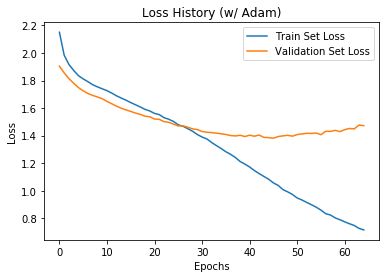

Model with SGDM
---------------
Test Accuracy on Model (w SGDM): 0.35742811501597443


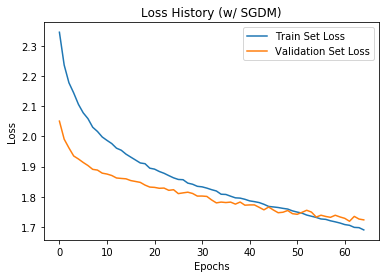

In [24]:
print("Model with Adam\n---------------")

mymodel_test_acc = get_test_acc(mymodel) ## GETTING REST ACC FOR MY MODEL w/ BN
print("Test Accuracy on Model (w/ Adam): " + str(mymodel_test_acc)) ## PRINTING TEST ACC

set_size = np.arange(len(accuracy_tr_mymodel))
plt.plot(set_size, losses_tr_mymodel, label='Train Set Loss')
plt.plot(set_size, losses_val_mymodel, label='Validation Set Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss History (w/ Adam)")
plt.legend()
plt.show()

print("Model with SGDM\n---------------")

model_sgdm_test_acc = get_test_acc(model_sgdm) ## GETTING REST ACC FOR MY MODEL w/o BN
print("Test Accuracy on Model (w SGDM): " + str(model_sgdm_test_acc)) ## PRINTING TEST ACC

set_size = np.arange(len(accuracy_tr_model_sgdm))
plt.plot(set_size, losses_tr_model_sgdm, label='Train Set Loss')
plt.plot(set_size, losses_val_model_sgdm, label='Validation Set Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss History (w/ SGDM)")
plt.legend()
plt.show()

In [25]:
## CLEARING OUT

del model_sgdm, losses_tr_model_sgdm, accuracy_tr_model_sgdm, losses_val_model_sgdm, accuracy_val_model_sgdm
torch.cuda.empty_cache()

#### After you have completed the training, save your best model using the following command
#### Upload your best model to Google Drive and copy your link here: https://drive.google.com/open?id=1CbMOeZbogvVi3myI1LWUqcoPM-fSFJ3q

In [26]:
student_id = 504181504
torch.save(mymodel.state_dict(), './{}.pth'.format(student_id))

In [27]:
## CLEARING OUT

del mymodel, losses_tr_mymodel, accuracy_tr_mymodel, losses_val_mymodel, accuracy_val_mymodel
torch.cuda.empty_cache()

In [28]:
## TESTING .PTH FILE

mymodel = YourModel(bnorm=True, dropout=True)
mymodel = mymodel.cuda()
mymodel.load_state_dict(torch.load('./{}.pth'.format(student_id)))
mymodel_test_acc = get_test_acc(mymodel)
print("Test Accuracy on Model (.pth model): " + str(mymodel_test_acc)) ## PRINTING TEST ACC

Test Accuracy on Model (.pth model): 0.5291533546325878
